# _Fit Your Learning Curves for Fun and Profit:_
## A Jupyter notebook version of ['Learning curves: Asymptotic values and rate of convergence' by Cortes et al. 1994](https://www.semanticscholar.org/paper/Learning-Curves-Asymptotic-Values-and-Rate-of-Cortes-Jackel/9878be2aeda54fb6e5f84bc700921641e2837824/pdf)

### David Nicholson
#### Graduate student, Emory Neuroscience

# Jupyter Day Atlanta

## https://github.com/NickleDave/learning-curves/

## learning curves
* plot of error against size of training data set
![learning curves](./cortes_etal_1994_fig2.png)
<center>**Fig.2 from Cortes et al. 1994**</center>

## why bother?
* Consider these hypothetical learning curves:
![more learning curves](./cortes_etal_1994_fig1.png)
<center>**Fig.1 from Cortes et al. 1994**</center>

## Can we avoid a training set size of 50k samples?
* Yes! (Cortes et al., 1994)
* We'll train up a bunch of models with data sets of intermediate size that are quicker to train
* Then we'll estimate the error for each size of training set
* Lastly we'll plot the error points and fit a curve

## The curve we'll fit: a power function
* has the form: $y = a + bx^\alpha$
 + with the parameters:
     * $a$, the asymptote
     * $b$, the scaling factor
     * $\alpha$, the power or exponent
     

## Cortes et al.'s approach

* Consider these learning curves again

![learning curves](./cortes_etal_1994_fig2.png)
<center>**Fig.2 from Cortes et al. 1994**</center>

* We're going to assume both the training error and test error obey power functions 
* Further assume both go in the limit to the same asymptote $a$
* These assumptions give us two equations:
 1. $\epsilon_{test} = a + \frac{b}{l^\alpha}$
 2. $\epsilon_{train} = a - \frac{c}{l^\beta}$

## Cortes et al.'s approach

* Let's take the sum and difference of those two equations
<br>&nbsp; &nbsp;3. The sum: $\epsilon_{test} + \epsilon_{train} = 2a + \frac{b}{l^\alpha} - \frac{c}{l^\beta}$
<br>&nbsp; &nbsp;4. The difference: $\epsilon_{test} - \epsilon_{train} = \frac{b}{l^\alpha} + \frac{c}{l^\beta}$

* Assume further that $\alpha$ = $\beta$ and that $b$ = $c$
* Equations 3 and 4 now reduce to:
<br>&nbsp; &nbsp;5. $\epsilon_{test} + \epsilon_{train} = 2a$
<br>&nbsp; &nbsp;6. $\epsilon_{test} - \epsilon_{train} = \frac{2b}{l^\alpha}$
<!--- br and &nbsp above are to prevent automated list numbering from resetting count --->

## Cortes et al.'s approach

What's so special about the equations in this form?
<br>&nbsp; &nbsp;5. $\epsilon_{test} + \epsilon_{train} = 2a$
<br>&nbsp; &nbsp;6. $\epsilon_{test} - \epsilon_{train} = \frac{2b}{l^\alpha}$

They suggest we can apply a log transform to the data.

Both should yield points we can fit with straight lines to get estimates of the parameters we want for our curve.
![log_transform](./cortes_etal_1994_fig3.png)
<center>**Fig.3 from Cortes et al. 1994**</center>

## Cortes et al.'s approach
![cortes_algorithm](./cortes_etal_1994_algobox.png)


## Ok, cool. How well does the Cortes et al. approach work?

In [1]:
#setup
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve

from learn_curves import predict_learning_curve

## Let's generate some learning curves using scikit-learn

In [2]:
#borrows heavily from http://scikit-learn.org/stable/modules/learning_curve.html
train_sizes=np.linspace(.1, 1.0, 5)
digits = load_digits()
X, y = digits.data, digits.target

cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=20,
                                   test_size=0.2, random_state=0)
estimator_NB = GaussianNB()
train_sizes_NB, train_scores_NB, test_scores_NB = learning_curve(
    estimator_NB, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)

train_error_NB = 1 - train_scores_NB
test_error_NB = 1 - test_scores_NB
train_error_mean_NB = np.mean(train_error_NB, axis=1)
test_error_mean_NB = np.mean(test_error_NB, axis=1)

estimator_SVC = SVC(gamma=0.001)
train_sizes_SVC, train_scores_SVC, test_scores_SVC = learning_curve(
    estimator_SVC, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)

train_error_SVC = 1 - train_scores_SVC
test_error_SVC = 1 - test_scores_SVC
train_error_mean_SVC = np.mean(train_error_SVC, axis=1)
test_error_mean_SVC = np.mean(test_error_SVC, axis=1)

## How's the fit look for Gaussian Naive Bayes?

In [3]:
a_NB,b_NB,alpha_NB = predict_learning_curve(train_sizes_NB,test_error_NB,train_error_NB)

powerfunc = lambda x,asymptote,scaling,exponent: asymptote + scaling * x**exponent
manypoints = np.arange(50,1650,50)
test_err_fit = powerfunc(manypoints,a_NB,b_NB,alpha_NB)
train_err_fit = powerfunc(manypoints,a_NB,-b_NB,alpha_NB) # note negative b to make powerfunc a - b * x ** c

(0, 0.7)

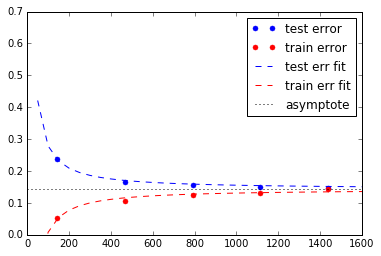

In [4]:
plt.plot(train_sizes_NB,test_error_mean_NB,'b.',markersize=10,label='test error')
plt.plot(train_sizes_NB,train_error_mean_NB,'r.',markersize=10,label='train error')
plt.plot(manypoints,test_err_fit,'b--',label='test err fit')
plt.plot(manypoints,train_err_fit,'r--',label='train err fit')
plt.axhline(a_NB,color='k',linestyle=':',label='asymptote')
plt.legend()
plt.ylim((0,0.7))

## How's the fit look for a Support Vector Classifier?

In [5]:
a_SVC,b_SVC,alpha_SVC = predict_learning_curve(train_sizes_SVC,test_error_SVC,train_error_SVC)

powerfunc = lambda x,asymptote,scaling,exponent: asymptote + scaling * x**exponent
manypoints = np.arange(50,1650,50)
test_err_fit_SVC = powerfunc(manypoints,a_SVC,b_SVC,alpha_SVC)
train_err_fit_SVC = powerfunc(manypoints,a_SVC,-b_SVC,alpha_SVC) # note negative b to make powerfunc a - b * x ** c

(0, 0.12)

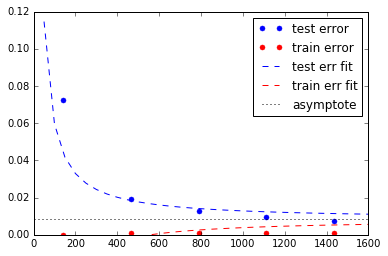

In [6]:
plt.plot(train_sizes_SVC,test_error_mean_SVC,'b.',markersize=10,label='test error')
plt.plot(train_sizes_SVC,train_error_mean_SVC,'r.',markersize=10,label='train error')
plt.plot(manypoints,test_err_fit_SVC,'b--',label='test err fit')
plt.plot(manypoints,train_err_fit_SVC,'r--',label='train err fit')
plt.axhline(a_SVC,color='k',linestyle=':',label='asymptote')
plt.legend()
plt.ylim((0,0.12))

## Now let's measure training error for just 'intermediate' training set sizes

In [7]:
#borrows heavily from http://scikit-learn.org/stable/modules/learning_curve.html
train_sizes_intmd = np.linspace(.1, 0.5, 10)
digits = load_digits()
X, y = digits.data, digits.target

cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=20,
                                   test_size=0.2, random_state=0)
train_sizes_NBintmd, train_scores_NBintmd, test_scores_NBintmd = learning_curve(
    estimator_NB, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes_intmd)

train_error_NBintmd = 1 - train_scores_NBintmd
test_error_NBintmd = 1 - test_scores_NBintmd
train_error_mean_NBintmd = np.mean(train_error_NBintmd, axis=1)
test_error_mean_NBintmd = np.mean(test_error_NBintmd, axis=1)

train_sizes_SVCintmd, train_scores_SVCintmd, test_scores_SVCintmd = learning_curve(
    estimator_SVC, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes_intmd)

train_error_SVCintmd = 1 - train_scores_SVCintmd
test_error_SVCintmd = 1 - test_scores_SVCintmd
train_error_mean_SVCintmd = np.mean(train_error_SVCintmd, axis=1)
test_error_mean_SVCintmd = np.mean(test_error_SVCintmd, axis=1)

## How's the fit from intermediate sized training sets compare to the first fit?

In [8]:
a_NBintmd,b_NBintmd,alpha_NBintmd = predict_learning_curve(train_sizes_NBintmd,test_error_NBintmd,train_error_NBintmd)

powerfunc = lambda x,asymptote,scaling,exponent: asymptote + scaling * x**exponent
manypoints = np.arange(50,1650,50)
test_err_fit = powerfunc(manypoints,a_NBintmd,b_NBintmd,alpha_NBintmd)
train_err_fit = powerfunc(manypoints,a_NBintmd,-b_NBintmd,alpha_NBintmd) # note negative b to make powerfunc a - b * x ** c

(0, 0.7)

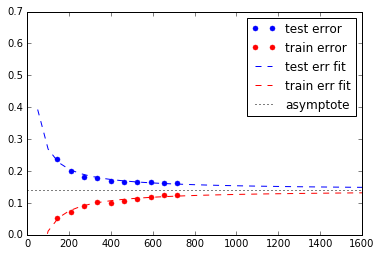

In [9]:
plt.plot(train_sizes_NBintmd,test_error_mean_NBintmd,'b.',markersize=10,label='test error')
plt.plot(train_sizes_NBintmd,train_error_mean_NBintmd,'r.',markersize=10,label='train error')
plt.plot(manypoints,test_err_fit,'b--',label='test err fit')
plt.plot(manypoints,train_err_fit,'r--',label='train err fit')
plt.axhline(a_NBintmd,color='k',linestyle=':',label='asymptote')
plt.legend()
plt.ylim((0,0.7))

In [10]:
print('estimated asymptote from all training set sizes:',a_NB)
print('estimated asymptote from intermediate training set sizes:',a_NBintmd)

estimated asymptote from all training set sizes: 0.143191221398
estimated asymptote from intermediate training set sizes: 0.140210481566


## Fit's pretty close, possibly better, for our test case using Gaussian Naive Bayes.
## And for a Support Vector Classifier?

In [11]:
a_SVCintmd,b_SVCintmd,alpha_SVCintmd = predict_learning_curve(train_sizes_SVCintmd,test_error_SVCintmd,train_error_SVCintmd)

powerfunc = lambda x,asymptote,scaling,exponent: asymptote + scaling * x**exponent
manypoints = np.arange(50,1650,50)
test_err_fit_SVCintmd = powerfunc(manypoints,a_SVCintmd,b_SVCintmd,alpha_SVCintmd)
train_err_fit_SVCintmd = powerfunc(manypoints,a_SVCintmd,-b_SVCintmd,alpha_SVCintmd) # note negative b to make powerfunc a - b * x ** c

(0, 0.12)

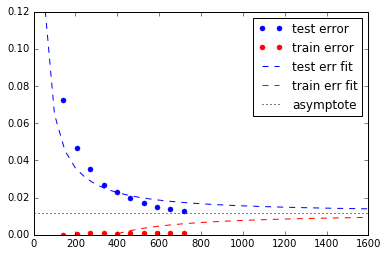

In [12]:
plt.plot(train_sizes_SVCintmd,test_error_mean_SVCintmd,'b.',markersize=10,label='test error')
plt.plot(train_sizes_SVCintmd,train_error_mean_SVCintmd,'r.',markersize=10,label='train error')
plt.plot(manypoints,test_err_fit_SVCintmd,'b--',label='test err fit')
plt.plot(manypoints,train_err_fit_SVCintmd,'r--',label='train err fit')
plt.axhline(a_SVCintmd,color='k',linestyle=':',label='asymptote')
plt.legend()
plt.ylim((0,0.12))

## Ok, the intermediate sized sets don't give a perfect fit for our SVC test case.
## But we get a "good enough" estimate of the asymptote to compare how our algorithms if we have "infinite" data

(0, 0.2)

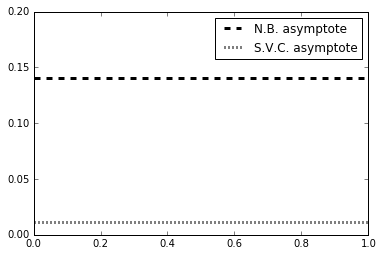

In [13]:
plt.axhline(a_NBintmd,color='k',linestyle='--',linewidth=3,label='N.B. asymptote')
plt.axhline(a_SVCintmd,color='k',linestyle=':',linewidth=3,label='S.V.C. asymptote')
plt.legend()
plt.ylim((0,0.2))

## So, based on fitting these examples curves from scikit-learn, the Cortes et al. method works.

## #TODO:
* Fit asymptote with least squares so we can compare with T test
* Can I reproduce the exact results from their paper? I'm already basically the same dataset